In [1]:
import pandas as pd
import numpy as np
import gc
import re


def _normalise_utc_offset(ts: str) -> str:
    """Return ``ts`` with ``UTC±HH`` offsets expanded to ``±HH:MM``.

    ``pd.to_datetime`` misinterprets offsets like ``UTC+5`` as ``UTC-05``.
    This helper rewrites them to a standard ``+05:00`` style so pandas
    parses them correctly.
    """
    if not isinstance(ts, str):
        return ts
    match = re.search(r"\sUTC([+-])(\d{1,2})(?::?(\d{2}))?$", ts)
    if match:
        sign, hour, minute = match.groups()
        hour = hour.zfill(2)
        minute = minute or "00"
        repl = f"{sign}{hour}:{minute}"
        ts = ts[: match.start()] + repl
    return ts

IMPUTE_RULES = {
    "ZERO": [
        'is_one_way','has_return','is_direct_leg0','is_direct_leg1',
        'both_direct','has_baggage','has_fees','is_cheapest',
        'is_most_expensive','n_segments_leg0','n_segments_leg1',
        'total_segments','is_popular_route','is_major_carrier',
    ],
    "MINUS1": [
        'booking_lead_days',
    ],
    "KEEP_NA": [
        'price_per_tax','tax_rate',
    ]
}

def smart_fill_numeric(df, zero_cols=()):
    """S\u00f3lo forz\u00e1 0 en binarios donde NA es imposible."""
    for c in zero_cols:
        if c in df.columns:
            df[c] = df[c].fillna(0).astype(np.int8)
    return df

# --- utils_fill.py ----------------------------------------------------------
def add_missing_flags(df: pd.DataFrame, cols):
    """Para cada col num\u00e9rica en `cols`, crea col+'_missing' y deja el NaN sin tocar."""
    for c in cols:
        if df[c].isna().any():
            df[f'{c}_missing'] = df[c].isna().astype(np.int8)
    return df

def fill_with_flag(df, col, value):
    flag = f"{col}_missing"
    if flag not in df.columns:
        df = add_missing_flags(df, [col])
    df[col] = df[col].fillna(value)
    return df

def unify_nan_strategy(df: pd.DataFrame) -> pd.DataFrame:
    """Standardise NaN handling and create missing-value indicators.

    Numeric columns keep their NaNs so LightGBM can leverage them
    directly except for those listed under ``ZERO`` or ``MINUS1``.
    ``ZERO`` columns have NaNs replaced with ``0`` (while recording
    the missingness) so they can remain integer typed. ``MINUS1``
    columns have NaNs replaced with ``-1`` and corresponding
    ``*_missing`` indicators added.  Missing flags are added for every
    column that contains NaNs.
    """

    # Replace any leftover infinities from feature engineering
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Columns where -1 encodes a specific meaning
    for col in IMPUTE_RULES["MINUS1"]:
        if col in df.columns:
            df = fill_with_flag(df, col, -1)

    # Columns where NaNs should become 0 so they remain integers
    for col in IMPUTE_RULES["ZERO"]:
        if col in df.columns:
            df = fill_with_flag(df, col, 0)
            # keep these features as small integers to save memory
            df[col] = df[col].astype(np.int8)

    # Ensure nullable integers with remaining NaNs become floats for LGBM
    for c in df.select_dtypes("Int64").columns:
        if df[c].isna().any():
            df[c] = df[c].astype("float32")

    for c in df.columns[df.isna().any()]:
        flag = f"{c}_missing"
        if flag not in df.columns:
            df[flag] = df[c].isna().astype(np.int8)

    return df

# ———————————————————————— CLEAN FEATURES ————————————————————————

def clean_features(X: pd.DataFrame,
                   X_test: pd.DataFrame,
                   *,
                   low_var_thresh: int = 1,
                   corr_thresh: float = 0.99,
                   verbose: bool = True):
    """Drop near-constant and highly correlated columns.

    Columns with ``low_var_thresh`` or fewer unique values (including ``NaN``)
    are removed. With the default of ``1``, only columns that contain a single
    unique value are dropped.
    """
    dropped = {"low_var": [], "high_corr": []}
    low_var = [c for c in X.columns if X[c].nunique(dropna=False) <= low_var_thresh]
    X = X.drop(columns=low_var)
    X_test = X_test.drop(columns=low_var, errors="ignore")
    dropped["low_var"] = low_var
    # Compute correlation without forcing NaNs to zero to avoid
    # spurious high correlations when missingness patterns overlap.
    # pandas' corr already uses pairwise deletion, so NaNs are skipped
    # on a per-column-pair basis.
    num_df = X.select_dtypes(include=np.number)
    corr = num_df.corr(min_periods=1).abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    # iterate over pairs in the upper triangle so we keep the first
    # column encountered and drop the second when correlation exceeds
    # the threshold
    to_drop = set()
    cols = list(upper.columns)
    for i, col1 in enumerate(cols[:-1]):
        for j in range(i + 1, len(cols)):
            col2 = cols[j]
            if pd.notna(upper.loc[col1, col2]) and upper.loc[col1, col2] >= corr_thresh:
                to_drop.add(col2)

    X = X.drop(columns=to_drop)
    X_test = X_test.drop(columns=to_drop, errors="ignore")
    dropped["high_corr"] = list(to_drop)
    if verbose:
        print(f"  • low-var  : {len(low_var)} cols drop")
        print(f"  • high-corr: {len(to_drop)} cols drop")
    return X, X_test, dropped

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Mem. usage decreased to {end_mem:5.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)")
    return df

def log_mem_usage(df: pd.DataFrame, label: str = "") -> None:
    """Print memory usage information for ``df``.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe whose memory footprint should be logged.
    label : str, optional
        Descriptive label printed alongside the memory stats.
    """

    tag = f"[{label}] " if label else ""
    usage = df.memory_usage(deep=True)
    total_mb = usage.sum() / 1024 ** 2
    print(f"{tag}Memory usage (deep):")
    print(usage.to_string())
    print(f"{tag}Total: {total_mb:.2f} MB")

def frequency_encode(train_series: pd.Series,
                     test_series: pd.Series | None = None,
                     *,
                     log: bool = True) -> tuple[pd.Series, pd.Series | None]:
    """Encode categories by their frequency derived from ``train_series``.

    Parameters
    ----------
    train_series : pd.Series
        Training column containing categorical values.
    test_series : pd.Series or None, optional
        Corresponding column from the test set. If provided, the same
        frequency mapping is applied.
    log : bool, default True
        Whether to apply ``np.log1p`` to the counts.

    Returns
    -------
    tuple
        Encoded training series and, when ``test_series`` is given, the
        encoded test series as well. Encodings are returned as
        ``float32``.
    """

    freq = train_series.value_counts()
    train_enc = train_series.map(freq).fillna(1)
    if test_series is not None:
        test_enc = test_series.map(freq).fillna(1)
    if log:
        train_enc = np.log1p(train_enc)
        if test_series is not None:
            test_enc = np.log1p(test_enc)
    train_enc = train_enc.astype("float32")
    if test_series is not None:
        test_enc = test_enc.astype("float32")
        return train_enc, test_enc
    return train_enc, None

def calculate_hit_rate_at_3(df_preds_with_true_and_rank):
    """Calculates HitRate@3."""
    hits = 0
    valid_queries_count = 0
    for ranker_id, group in df_preds_with_true_and_rank.groupby('ranker_id'):
        if len(group) <= 10:
            continue
        valid_queries_count += 1
        true_selected_item = group[group['selected'] == 1]
        if not true_selected_item.empty:
            rank_of_true_item = true_selected_item.iloc[0]['predicted_rank']
            if rank_of_true_item <= 3:
                hits += 1
    if valid_queries_count == 0:
        return 0.0
    return hits / valid_queries_count

def lgb_hit_rate_at_3(labels, preds, weight=None, group=None):
    """LightGBM evaluation metric for HitRate@3.

    Parameters
    ----------
    labels : array-like
        True labels for each item.
    preds : array-like
        Predicted scores for each item.
    weight : array-like or None
        Unused sample weights.
    group : array-like or None
        Group sizes for ranking tasks.

    Returns
    -------
    tuple
        ``("hr@3", score, True)`` where ``score`` is the HitRate@3 value and
        ``True`` indicates that higher values are better.
    """
    if group is None:
        raise ValueError("Group information is required to compute HitRate@3")

    hits = 0
    valid_queries = 0
    idx = 0
    for g in group:
        end = idx + g
        if g > 10:
            valid_queries += 1
            group_preds = preds[idx:end]
            group_labels = labels[idx:end]
            if np.any(group_labels == 1):
                true_idx = np.where(group_labels == 1)[0][0]
                rank = (-group_preds).argsort()
                rank_pos = np.where(rank == true_idx)[0][0] + 1
                if rank_pos <= 3:
                    hits += 1
        idx = end

    score = hits / valid_queries if valid_queries else 0.0
    return "hr@3", score, True

# -------------------------------------------------------------------
# Feature engineering helpers

def create_features(df):
    def hms_to_minutes(s: pd.Series) -> np.ndarray:
        out = np.full(len(s), np.nan, dtype="float32")
        if s.notna().any():
            ss = s.astype(str)
            hms = ss.str.extract(r'^(?P<h>\d{1,2}):(?P<m>\d{1,2})(?::\d{1,2})?$')
            mask = hms.notna().all(axis=1)
            out[mask] = hms['h'].astype(float).values[mask] * 60 + hms['m'].astype(float).values[mask]
            iso = ss.str.extract(r'^PT(?:(?P<ih>\d+)H)?(?:(?P<im>\d+)M)?')
            mask = iso.notna().any(axis=1)
            out[mask] = iso['ih'].fillna(0).astype(float).values[mask] * 60 + iso['im'].fillna(0).astype(float).values[mask]
            mask = ss.str.fullmatch(r'\d+(\.\d+)?')
            out[mask] = ss[mask].astype(float).values
        return out

    dur_cols = [
        'legs0_duration', 'legs1_duration',
        'legs0_segments0_duration', 'legs0_segments1_duration',
        'legs1_segments0_duration', 'legs1_segments1_duration'
    ]
    present = [c for c in dur_cols if c in df.columns]
    for c in present:
        df[c] = hms_to_minutes(df[c]).astype('float32')
    df = add_missing_flags(df, present)

    legs0 = df['legs0_duration'] if 'legs0_duration' in df.columns else np.nan
    legs1 = df['legs1_duration'] if 'legs1_duration' in df.columns else np.nan
    df['total_duration']  = legs0.fillna(0) + legs1.fillna(0)
    df['duration_ratio']  = legs0 / legs1
    bad = (df['duration_ratio'] < 0) | (df['duration_ratio'] > 5)
    df.loc[bad, 'duration_ratio'] = np.nan
    if {'totalPrice','taxes'}.issubset(df.columns):
        feat = {}
        feat["price_per_tax"] = df["totalPrice"] / (df["taxes"] + 1)
        feat["tax_rate"]      = df["taxes"] / (df["totalPrice"] + 1)
        feat["log_price"]     = np.log1p(df["totalPrice"])
    else:
        feat = {}
    legs0 = df.get("legs0_duration")
    legs1 = df.get("legs1_duration")
    seg_counts = {}
    for leg in (0, 1):
        pat = rf'^legs{leg}_segments\d+_departureFrom_airport_iata$'
        seg_cols = [c for c in df.columns if re.match(pat, c)]
        seg_counts[leg] = (
            df[seg_cols].notna().sum(axis=1).astype("int8") if seg_cols else 0
        )
    feat["total_segments"] = seg_counts[0] + seg_counts[1]
    feat["is_one_way"] = (
        df["legs1_duration"].isna() |
        df["legs1_segments0_departureFrom_airport_iata"].isna()
    ).astype("int8")
    feat["has_return"] = 1 - feat["is_one_way"]
    grp = df.groupby("ranker_id")
    #feat["price_pct_rank"]    = grp["totalPrice"].rank(pct=True)
    #feat["duration_rank"]     = grp["total_duration"].rank()
    #feat["duration_pct_rank"] = grp["total_duration"].rank(pct=True)
    feat["is_cheapest"]       = (grp["totalPrice"].transform("min") == df["totalPrice"]).astype("int8")
    feat["is_most_expensive"] = (grp["totalPrice"].transform("max") == df["totalPrice"]).astype("int8")
    ff = df["frequentFlyer"].fillna("").astype(str)
    feat["n_ff_programs"] = ff.str.count("/") + (ff != "")
    carrier_cols = ["legs0_segments0_marketingCarrier_code", "legs1_segments0_marketingCarrier_code"]
    present_airlines = set()
    for col in carrier_cols:
        if col in df.columns:
            present_airlines.update(df[col].dropna().unique())
    ff_flags = {}
    for al in ["SU", "S7", "U6", "TK"]:
        if al in present_airlines:
            ff_flags[al] = ff.str.contains(fr"\b{al}\b").astype("int8")
    feat["ff_matches_carrier"] = 0
    if "legs0_segments0_marketingCarrier_code" in df.columns:
        for al, flag in ff_flags.items():
            feat["ff_matches_carrier"] |= (
                (flag == 1)
                & (df["legs0_segments0_marketingCarrier_code"] == al)
            ).astype("int8")
    feat["baggage_total"] = (
        df["legs0_segments0_baggageAllowance_quantity"].fillna(0)
        + df["legs1_segments0_baggageAllowance_quantity"].fillna(0)
    )
    feat["total_fees"]  = df["miniRules0_monetaryAmount"].fillna(0) + df["miniRules1_monetaryAmount"].fillna(0)
    feat["fee_rate"]    = feat["total_fees"] / (df["totalPrice"] + 1)
    for col in ("legs0_departureAt", "legs0_arrivalAt", "legs1_departureAt", "legs1_arrivalAt"):
        if col in df.columns:
            dt = pd.to_datetime(df[col], errors="coerce")
            feat[f"{col}_hour"]      = dt.dt.hour.astype("float16")
            feat[f"{col}_weekday"]   = dt.dt.weekday.astype("float16")
            h = dt.dt.hour
            feat[f"{col}_business_time"] = (((6 <= h) & (h <= 9)) | ((17 <= h) & (h <= 20))).astype("int8")
    feat["is_direct_leg0"] = (seg_counts[0] == 1).astype("int8")
    feat["is_direct_leg1"] = np.where(
        feat["is_one_way"] == 1,
        0,
        (seg_counts[1] == 1).astype("int8"),
    )
    feat["both_direct"]    = (feat["is_direct_leg0"] & feat["is_direct_leg1"]).astype("int8")
    feat["is_vip_freq"]  = ((df["isVip"] == 1) | (feat["n_ff_programs"] > 0)).astype("int8")
    feat["group_size"]    = df.groupby("ranker_id")["Id"].transform("count")
    if "legs0_segments0_marketingCarrier_code" in df.columns:
        feat["is_major_carrier"] = df["legs0_segments0_marketingCarrier_code"].isin(["SU","S7","U6"]).astype("int8")
    else:
        feat["is_major_carrier"] = 0
    popular = {"MOWLED/LEDMOW","LEDMOW/MOWLED","MOWLED","LEDMOW","MOWAER/AERMOW"}
    feat["is_popular_route"] = df["searchRoute"].isin(popular).astype("int8")
    feat["avg_cabin_class"] = df[["legs0_segments0_cabinClass","legs1_segments0_cabinClass"]].mean(axis=1)
    if 'nationality' in df.columns and 'legs0_segments0_marketingCarrier_code' in df.columns:
        feat['nat_carrier_leg0'] = (
            df['nationality'].astype('object').fillna('missing').astype(str) + '_' +
            df['legs0_segments0_marketingCarrier_code'].astype('object').fillna('missing').astype(str)
        )
    if 'nationality' in df.columns and 'legs1_segments0_marketingCarrier_code' in df.columns:
        feat['nat_carrier_leg1'] = (
            df['nationality'].astype('object').fillna('missing').astype(str) + '_' +
            df['legs1_segments0_marketingCarrier_code'].astype('object').fillna('missing').astype(str)
        )
    df = pd.concat([df, pd.DataFrame(feat, index=df.index)], axis=1)
    df = df.loc[:, ~df.columns.duplicated(keep="first")]
    for col in df.select_dtypes(include="object").columns:
        if pd.api.types.is_categorical_dtype(df[col]):
            if "missing" not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories(["missing"])
            df[col] = df[col].fillna("missing")
        else:
            df[col] = df[col].astype("category")
            df[col] = df[col].cat.add_categories(["missing"]).fillna("missing")
    return df

def create_initial_datetime_features(df):
    loaded_cols = df.columns
    potential_dt_cols = ['requestDate', 'legs0_departureAt', 'legs0_arrivalAt', 'legs1_departureAt', 'legs1_arrivalAt']
    for col in potential_dt_cols:
        if col in loaded_cols:
            if not pd.api.types.is_datetime64_any_dtype(df[col]):
                current_dtype = df[col].dtype
                print(f"Converting column {col} (current dtype: {current_dtype}) to datetime.")
                df[col] = pd.to_datetime(
                    df[col]
                    .astype(str)
                    .map(_normalise_utc_offset),
                    errors="coerce",
                )
    return df

def create_remaining_features(df, is_train=True):
    potential_dt_cols_for_components = ['legs0_departureAt', 'legs0_arrivalAt', 'legs1_departureAt', 'legs1_arrivalAt']
    for col in potential_dt_cols_for_components:
        if col in df.columns and pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col + '_hour'] = df[col].dt.hour.astype(np.int8, errors='ignore')
            df[col + '_dow'] = df[col].dt.dayofweek.astype(np.int8, errors='ignore')
    if (
        'legs0_departureAt' in df.columns
        and 'requestDate' in df.columns
        and pd.api.types.is_datetime64_any_dtype(df['legs0_departureAt'])
        and pd.api.types.is_datetime64_any_dtype(df['requestDate'])
    ):
        df['booking_lead_days'] = (
            df['legs0_departureAt'] - df['requestDate']
        ).dt.total_seconds() / (24 * 60 * 60)
    else:
        df['booking_lead_days'] = np.nan
    df['booking_lead_days'] = df['booking_lead_days'].astype(np.float32)
    if {'legs1_departureAt','legs0_departureAt'}.issubset(df.columns):
        df['trip_days'] = (df['legs1_departureAt'] - df['legs0_departureAt']).dt.days.astype('float32')
    else:
        df['trip_days'] = np.nan
    if 'legs0_departureAt' in df.columns and 'requestDate' in df.columns and pd.api.types.is_datetime64_any_dtype(df['legs0_departureAt']) and pd.api.types.is_datetime64_any_dtype(df['requestDate']):
        df['booking_to_trip_days'] = (df['legs0_departureAt'] - df['requestDate']).dt.days.astype('float32')
    else:
        df['booking_to_trip_days'] = np.nan
    if 'legs0_departureAt' in df.columns and pd.api.types.is_datetime64_any_dtype(df['legs0_departureAt']):
        df['ida_fds'] = df['legs0_departureAt'].dt.dayofweek.isin([5,6]).astype(np.int8)
        df['ida_comercial'] = df['legs0_departureAt'].dt.hour.between(7,19).astype(np.int8)
    if 'legs1_departureAt' in df.columns and pd.api.types.is_datetime64_any_dtype(df['legs1_departureAt']):
        df['volta_fds'] = df['legs1_departureAt'].dt.dayofweek.isin([5,6]).astype(np.int8)
        df['volta_comercial'] = df['legs1_departureAt'].dt.hour.between(7,19).astype(np.int8)
    if 'searchRoute' in df.columns:
        df['searchRoute'] = df['searchRoute'].astype(str)
        routes = df['searchRoute'].str.split('/', n=1, expand=True)
        df['route_ida'] = routes[0]
        df['route_volta'] = routes[1]
        df['ida_from'] = df['route_ida'].str[:3]
        df['ida_to'] = df['route_ida'].str[3:]
        df['volta_from'] = df['route_volta'].str[:3]
        df['volta_to'] = df['route_volta'].str[3:]
    if 'legs0_segments0_duration' in df.columns:
        df['legs0_duration_minutes'] = df['legs0_segments0_duration'].astype('float32')
        df.drop(columns=['legs0_segments0_duration'], inplace=True)
    if 'searchRoute' in df.columns:
        _ = df['searchRoute'].astype(str).str.contains('/')
    if 'legs1_departureAt' in df.columns and pd.api.types.is_datetime64_any_dtype(df['legs1_departureAt']):
        df['num_legs'] = 1 + df['legs1_departureAt'].notna().astype(np.int8)
    elif 'legs1_departureAt' in df.columns:
        df['num_legs'] = 1 + pd.to_datetime(df['legs1_departureAt'].astype(str), errors='coerce').notna().astype(np.int8)
    else:
        df['num_legs'] = 1
    for leg in range(2):
        pattern = fr'^legs{leg}_segments\d+_departureFrom_airport_iata$'
        seg_cols = [c for c in df.columns if re.match(pattern, c)]
        if seg_cols:
            df[f'num_segments_leg{leg}'] = df[seg_cols].notna().sum(axis=1).astype(np.int8)
        else:
            df[f'num_segments_leg{leg}'] = 0
    df['total_segments'] = (df['num_segments_leg0'] + df['num_segments_leg1']).astype(np.int8)
    for dur_col in ['legs0_duration', 'legs1_duration']:
        if not np.issubdtype(df[dur_col].dtype, np.number):
            df[dur_col] = pd.to_numeric(df[dur_col].astype(str), errors='coerce')
    df['total_flight_duration'] = (df['legs0_duration'] + df['legs1_duration']).astype(np.float32)
    if 'totalPrice' in df.columns and 'taxes' in df.columns:
        df['price_per_duration'] = (
            df['totalPrice'] / (df['total_flight_duration'] + 1e-6)
        ).fillna(0).astype(np.float32)
    else:
        df['price_per_duration'] = 0.0
    if 'pricingInfo_isAccessTP' in df.columns:
        df['is_compliant'] = df['pricingInfo_isAccessTP'].fillna(0).astype(np.int8)
    else:
        df['is_compliant'] = -1
    if 'legs0_segments0_baggageAllowance_quantity' in df.columns:
        df['baggage_leg0_included'] = (df['legs0_segments0_baggageAllowance_quantity'].fillna(0) > 0).astype(np.int8)
    else:
        df['baggage_leg0_included'] = -1
    if 'legs1_segments0_baggageAllowance_quantity' in df.columns:
        df['baggage_leg1_included'] = (df['legs1_segments0_baggageAllowance_quantity'].fillna(0) > 0).astype(np.int8)
        if 'baggage_leg0_included' in df.columns and df['baggage_leg0_included'].iloc[0] != -1:
            df['baggage_both_legs_included'] = (df['baggage_leg0_included'] & df['baggage_leg1_included']).astype(np.int8)
        else:
            df['baggage_both_legs_included'] = -1
    else:
        df['baggage_leg1_included'] = 0
        if 'baggage_leg0_included' in df.columns and df['baggage_leg0_included'].iloc[0] != -1:
            df['baggage_both_legs_included'] = df['baggage_leg0_included'].astype(np.int8)
        else:
            df['baggage_both_legs_included'] = -1
    group_key = 'ranker_id'
    if group_key not in df.columns:
        return df
    cols_for_group_features = []
    user_company_cats_loaded = [c for c in ['sex', 'nationality', 'isVip'] if c in df.columns]
    for col in user_company_cats_loaded:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(str)
        df[col] = df[col].fillna('missing').astype('category')
    binary_cols_loaded = [c for c in ['bySelf', 'isAccess3D'] if c in df.columns]
    for col in binary_cols_loaded:
        df[col] = df[col].fillna(0).astype(np.int8)
    df = reduce_mem_usage(df, verbose=False)
    return df
def dur_stats(df):
    for col in ['legs0_duration', 'legs1_duration']:
        print(col,
              "\u2192", df[col].dtype,
              "| NaN:", df[col].isna().mean(),
              "| 0.0:", (df[col] == 0).mean(),
              "| -1:",  (df[col] == -1).mean(),
              "| min:", df[col].min(),
              "| max:", df[col].max())

def check_rank_permutation(group):
    N = len(group)
    sorted_ranks = sorted(list(group['selected']))
    expected_ranks = list(range(1, N + 1))
    if sorted_ranks != expected_ranks:
        print(f"Invalid rank permutation for ranker_id: {group['ranker_id'].iloc[0]}")
        print(f"Expected: {expected_ranks}, Got: {sorted_ranks}")
        return False
    return True


def readme() -> str:
    """Return a short description of this project's purpose.

    This helper can be imported by notebooks or scripts to quickly
    display basic information about the utilities and pipeline
    contained in this repository.
    """

    return (
        "Utilities and pipeline for the AeroClub RecSys 2025 dataset. "
        "The code includes feature engineering helpers and a LightGBM "
        "training pipeline (see :mod:`pipeline`)."
    )

In [2]:

import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importances(feature_importances, top_n=20):
    """Display a bar chart of the top N feature importances."""
    fi_sorted = feature_importances.sort_values('average', ascending=False).head(top_n)
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, max(3, top_n * 0.4)))
    sns.barplot(data=fi_sorted, x='average', y='feature', orient='h', palette='viridis')
    plt.xlabel('Importance (average)')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Feature Importances')
    plt.tight_layout()
    plt.show()
    table = fi_sorted[['feature', 'average']].reset_index(drop=True)
    table.index = table.index + 1
    print(table)


### Helper: `plot_feature_importances`
Displays a horizontal bar chart of the most important features.

```python
plot_feature_importances(feature_importances, top_n=20)
```


Loading a subset of columns for train_df...
[train_df loaded] Memory usage (deep):
Index                                          145162976
Id                                             145162976
ranker_id                                     1614938108
selected                                       145162976
profileId                                      145162976
companyID                                      145162976
requestDate                                    145162976
totalPrice                                     145162976
taxes                                          145162976
legs0_departureAt                             1379048272
legs0_arrivalAt                               1379048272
legs0_duration                                1180848474
legs1_departureAt                             1150913820
legs1_arrivalAt                               1150913820
legs1_duration                                1000833781
legs0_segments0_departureFrom_airport_iata    1088722131
legs0

/tmp/ipykernel_13/439099119.py:431: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(


Converting column legs1_arrivalAt (current dtype: object) to datetime.


/tmp/ipykernel_13/439099119.py:431: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(


[train after datetime] Memory usage (deep):
Index                                               132
Id                                             72988240
ranker_id                                     811994170
selected                                       72988240
profileId                                      72988240
companyID                                      72988240
requestDate                                    72988240
totalPrice                                     72988240
taxes                                          72988240
legs0_departureAt                              72988240
legs0_arrivalAt                                72988240
legs0_duration                                593723650
legs1_departureAt                              72988240
legs1_arrivalAt                                72988240
legs1_duration                                503341548
legs0_segments0_departureFrom_airport_iata    547411764
legs0_segments0_arrivalTo_airport_iata        547411614
legs

/tmp/ipykernel_13/634299943.py:79: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if 'frequentFlyer' in df.columns and pd.api.types.is_categorical_dtype(df['frequentFlyer']):


Mem. usage decreased to 1107.74 Mb (33.5% reduction)
[train after first reduce] Memory usage (deep):
Index                                              132
Id                                            36494120
ranker_id                                     43304137
selected                                       9123530
profileId                                     36494120
companyID                                     36494120
requestDate                                   72988240
totalPrice                                    36494120
taxes                                         36494120
legs0_departureAt                             72988240
legs0_arrivalAt                               72988240
legs0_duration                                18364181
legs1_departureAt                             72988240
legs1_arrivalAt                               72988240
legs1_duration                                18344025
legs0_segments0_departureFrom_airport_iata    18277076
legs0_segments0_arr

/tmp/ipykernel_13/439099119.py:305: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out[mask] = iso['ih'].fillna(0).astype(float).values[mask] * 60 + iso['im'].fillna(0).astype(float).values[mask]
/tmp/ipykernel_13/439099119.py:305: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out[mask] = iso['ih'].fillna(0).astype(float).values[mask] * 60 + iso['im'].fillna(0).astype(float).values[mask]
/tmp/ipykernel_13/439099119.py:305: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call resu

[train after unify] Memory usage (deep):
Index                                                       132
Id                                                     36494120
ranker_id                                              43304137
selected                                                9123530
profileId                                              36494120
companyID                                              36494120
requestDate                                            72988240
totalPrice                                             36494120
taxes                                                  36494120
legs0_departureAt                                      72988240
legs0_arrivalAt                                        72988240
legs0_duration                                         18247060
legs1_departureAt                                      72988240
legs1_arrivalAt                                        72988240
legs1_duration                                         18247060

/tmp/ipykernel_13/634299943.py:79: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if 'frequentFlyer' in df.columns and pd.api.types.is_categorical_dtype(df['frequentFlyer']):


Mem. usage decreased to 876.56 Mb (32.4% reduction)
[test after first reduce] Memory usage (deep):
Index                                         55182208
Id                                            27591104
ranker_id                                     32673471
profileId                                     27591104
companyID                                     27591104
requestDate                                   55182208
totalPrice                                    27591104
taxes                                         27591104
legs0_departureAt                             55182208
legs0_arrivalAt                               55182208
legs0_duration                                13896482
legs1_departureAt                             55182208
legs1_arrivalAt                               55182208
legs1_duration                                13882771
legs0_segments0_departureFrom_airport_iata    13821248
legs0_segments0_arrivalTo_airport_iata        13836884
legs0_segments0_marke

/tmp/ipykernel_13/439099119.py:305: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out[mask] = iso['ih'].fillna(0).astype(float).values[mask] * 60 + iso['im'].fillna(0).astype(float).values[mask]
/tmp/ipykernel_13/439099119.py:305: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out[mask] = iso['ih'].fillna(0).astype(float).values[mask] * 60 + iso['im'].fillna(0).astype(float).values[mask]
/tmp/ipykernel_13/439099119.py:305: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call resu

[test after unify] Memory usage (deep):
Index                                                  55182208
Id                                                     27591104
ranker_id                                              32673471
profileId                                              27591104
companyID                                              27591104
requestDate                                            55182208
totalPrice                                             27591104
taxes                                                  27591104
legs0_departureAt                                      55182208
legs0_arrivalAt                                        55182208
legs0_duration                                         13795552
legs1_departureAt                                      55182208
legs1_arrivalAt                                        55182208
legs1_duration                                         13795552
legs0_segments0_departureFrom_airport_iata             13821248


/tmp/ipykernel_13/634299943.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_groups = pd.DataFrame({'ranker_id': ranker_ids.iloc[train_idx]}).groupby('ranker_id', sort=False).size().to_list()
/tmp/ipykernel_13/634299943.py:259: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_groups = pd.DataFrame({'ranker_id': ranker_ids.iloc[val_idx]}).groupby('ranker_id', sort=False).size().to_list()
/tmp/ipykernel_13/634299943.py:275: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=T

Fold 1 HitRate@3: 0.4835
====== Fold 2/5 ======


/tmp/ipykernel_13/634299943.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_groups = pd.DataFrame({'ranker_id': ranker_ids.iloc[train_idx]}).groupby('ranker_id', sort=False).size().to_list()
/tmp/ipykernel_13/634299943.py:259: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_groups = pd.DataFrame({'ranker_id': ranker_ids.iloc[val_idx]}).groupby('ranker_id', sort=False).size().to_list()
/tmp/ipykernel_13/634299943.py:275: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=T

Fold 2 HitRate@3: 0.4868
====== Fold 3/5 ======


/tmp/ipykernel_13/634299943.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_groups = pd.DataFrame({'ranker_id': ranker_ids.iloc[train_idx]}).groupby('ranker_id', sort=False).size().to_list()
/tmp/ipykernel_13/634299943.py:259: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_groups = pd.DataFrame({'ranker_id': ranker_ids.iloc[val_idx]}).groupby('ranker_id', sort=False).size().to_list()
/tmp/ipykernel_13/634299943.py:275: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=T

Fold 3 HitRate@3: 0.4872
====== Fold 4/5 ======


/tmp/ipykernel_13/634299943.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_groups = pd.DataFrame({'ranker_id': ranker_ids.iloc[train_idx]}).groupby('ranker_id', sort=False).size().to_list()
/tmp/ipykernel_13/634299943.py:259: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_groups = pd.DataFrame({'ranker_id': ranker_ids.iloc[val_idx]}).groupby('ranker_id', sort=False).size().to_list()
/tmp/ipykernel_13/634299943.py:275: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=T

Fold 4 HitRate@3: 0.4865
====== Fold 5/5 ======


/tmp/ipykernel_13/634299943.py:258: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train_groups = pd.DataFrame({'ranker_id': ranker_ids.iloc[train_idx]}).groupby('ranker_id', sort=False).size().to_list()
/tmp/ipykernel_13/634299943.py:259: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  val_groups = pd.DataFrame({'ranker_id': ranker_ids.iloc[val_idx]}).groupby('ranker_id', sort=False).size().to_list()
/tmp/ipykernel_13/634299943.py:275: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=T

Fold 5 HitRate@3: 0.4822


/tmp/ipykernel_13/634299943.py:283: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  oof_df['predicted_rank'] = oof_df.groupby('ranker_id')['score'].rank(method='first', ascending=False).astype(int)
/tmp/ipykernel_13/439099119.py:236: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ranker_id, group in df_preds_with_true_and_rank.groupby('ranker_id'):



Overall OOF HitRate@3: 0.4852
Mean Fold HitRate@3: 0.4852

Top Feature Importances:


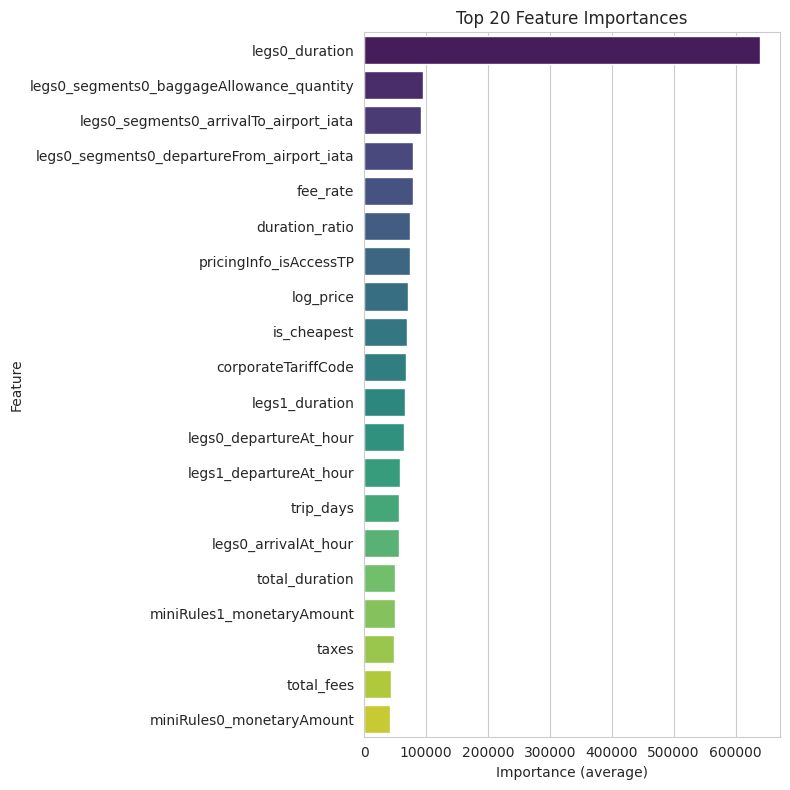

                                       feature        average
1                               legs0_duration  639824.121219
2    legs0_segments0_baggageAllowance_quantity   95263.790626
3       legs0_segments0_arrivalTo_airport_iata   92779.047765
4   legs0_segments0_departureFrom_airport_iata   79467.073027
5                                     fee_rate   79375.260594
6                               duration_ratio   74944.739316
7                       pricingInfo_isAccessTP   73783.622364
8                                    log_price   70624.775268
9                                  is_cheapest   69651.170188
10                         corporateTariffCode   68586.078658
11                              legs1_duration   66875.346795
12                      legs0_departureAt_hour   63999.948870
13                      legs1_departureAt_hour   57708.130906
14                                   trip_days   56845.101721
15                        legs0_arrivalAt_hour   56350.064599
16      

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
import gc


# --- columnas que quiero ignorar en TODO el pipeline ---
COL_BLACKLIST = {
    
}

initial_core_columns = [
    'Id', 'ranker_id', 'selected', 'profileId', 'companyID',
    'requestDate', 'totalPrice', 'taxes',
    'legs0_departureAt', 'legs0_arrivalAt', 'legs0_duration',
    'legs1_departureAt', 'legs1_arrivalAt', 'legs1_duration',
    'legs0_segments0_departureFrom_airport_iata', 'legs0_segments0_arrivalTo_airport_iata',
    'legs0_segments0_marketingCarrier_code', 'legs0_segments0_cabinClass',
    'legs0_segments0_baggageAllowance_quantity',
    'searchRoute',
    'pricingInfo_isAccessTP', 'pricingInfo_passengerCount',
    'sex', 'nationality', 'isVip',
    'miniRules0_monetaryAmount', 'miniRules0_percentage',
    'miniRules1_monetaryAmount', 'miniRules1_percentage'
]

extra_cols = [
    'frequentFlyer', 'corporateTariffCode',
    'legs1_segments0_baggageAllowance_quantity',
    'legs1_segments0_cabinClass',
    'legs1_segments0_departureFrom_airport_iata',
    'legs1_segments0_arrivalTo_airport_iata',
    'legs1_segments0_marketingCarrier_code',
]

initial_core_columns += [c for c in extra_cols if c not in initial_core_columns]
initial_core_columns = [c for c in initial_core_columns if c not in COL_BLACKLIST]
initial_core_columns_test = [c for c in initial_core_columns if c != 'selected']


def load_data(sample_frac=0.5, random_seed=42):
    print("Loading a subset of columns for train_df...")
    train_df = pd.read_parquet('/kaggle/input/aeroclub-recsys-2025/train.parquet', columns=initial_core_columns)
    log_mem_usage(train_df, "train_df loaded")

    unique_ids = train_df['ranker_id'].unique()
    n_keep = int(len(unique_ids) * sample_frac)
    rng = np.random.RandomState(random_seed)
    sampled_rankers = rng.choice(unique_ids, size=n_keep, replace=False)
    train_df = train_df[train_df['ranker_id'].isin(sampled_rankers)].reset_index(drop=True)
    log_mem_usage(train_df, "train_df sampled")
    print(f"Train reducido (grupos completos): {train_df.shape}")
    bad_groups = train_df.groupby('ranker_id').size().lt(11).sum()
    print(f"Grupos con <11 filas: {bad_groups}")

    print("Loading a subset of columns for test_df...")
    test_df = pd.read_parquet('/kaggle/input/aeroclub-recsys-2025/test.parquet', columns=initial_core_columns_test)
    log_mem_usage(test_df, "test_df loaded")
    sample_submission_df = pd.read_parquet('/kaggle/input/aeroclub-recsys-2025/sample_submission.parquet')

    if 'Id' in test_df.columns and 'ranker_id' in test_df.columns:
        test_ids_df = test_df[['Id', 'ranker_id']]
    else:
        print("Warning: 'Id' or 'ranker_id' not found in loaded test_df columns. Submission might fail.")
        try:
            test_ids_df = pd.read_parquet('/kaggle/input/aeroclub-recsys-2025/test.parquet', columns=['Id', 'ranker_id'])
        except Exception:
            test_ids_df = pd.DataFrame()
    return train_df, test_df, sample_submission_df, test_ids_df

def preprocess_dataframe(df, is_train=True):
    df = create_initial_datetime_features(df)
    log_mem_usage(df, f"{'train' if is_train else 'test'} after datetime")
    obj_cols = df.select_dtypes('object').columns
    for c in obj_cols:
        df[c] = df[c].astype('category')
    if 'frequentFlyer' in df.columns and pd.api.types.is_categorical_dtype(df['frequentFlyer']):
        df['frequentFlyer'] = df['frequentFlyer'].cat.add_categories(['']).fillna('')
    binary_candidates = df.select_dtypes(include=['number', 'bool']).columns
    binary_cols = []
    for c in binary_candidates:
        vals = df[c].dropna().unique()
        if len(vals) <= 2 and set(vals).issubset({0, 1}):
            binary_cols.append(c)
    df = smart_fill_numeric(df, zero_cols=binary_cols)
    df = reduce_mem_usage(df)
    log_mem_usage(df, f"{'train' if is_train else 'test'} after first reduce")
    df = create_features(df)
    df = create_remaining_features(df, is_train=is_train)
    df = unify_nan_strategy(df)
    log_mem_usage(df, f"{'train' if is_train else 'test'} after unify")
    df = reduce_mem_usage(df)
    log_mem_usage(df, f"{'train' if is_train else 'test'} final")
    return df

def prepare_matrices(train_df_processed, test_df_processed):
    TOP_N = 10
    airport_col = 'legs0_segments0_departureFrom_airport_iata'
    freq = train_df_processed[airport_col].value_counts()
    for df in (train_df_processed, test_df_processed):
        df['dep_freq'] = df[airport_col].map(freq).fillna(1).astype('int32')
    top_hubs = freq.head(TOP_N).index
    for df in (train_df_processed, test_df_processed):
        df['dep_is_hub'] = df[airport_col].isin(top_hubs).astype('int8')

    raw_datetime_col_names = [
        'requestDate', 'legs0_departureAt', 'legs0_arrivalAt',
        'legs1_departureAt', 'legs1_arrivalAt'
    ]
    id_cols_and_target = ['Id', 'ranker_id', 'selected', 'profileId', 'companyID', 'searchRoute']
    DROP_COLS = [
    ]
    train_df_processed.drop(
        columns=[c for c in DROP_COLS if c in train_df_processed.columns],
        inplace=True,
        errors="ignore",
    )
    test_df_processed.drop(
        columns=[c for c in DROP_COLS if c in test_df_processed.columns],
        inplace=True,
        errors="ignore",
    )

    excluded_for_X_train = id_cols_and_target + raw_datetime_col_names
    train_feature_cols = [c for c in train_df_processed.columns if c not in excluded_for_X_train]
    X = train_df_processed[train_feature_cols].reset_index(drop=True)
    y = train_df_processed['selected'].reset_index(drop=True)
    train_ranker_ids = train_df_processed['ranker_id'].reset_index(drop=True)
    X_test = test_df_processed.reindex(columns=train_feature_cols)

    num_cols_test = X_test.select_dtypes(exclude="category").columns
    X_test[num_cols_test] = X_test[num_cols_test].replace([np.inf, -np.inf], np.nan)

    num_cols_train = X.select_dtypes(exclude="category").columns
    X[num_cols_train] = X[num_cols_train].replace([np.inf, -np.inf], np.nan)
    cat_cols = X_test.select_dtypes("category").columns
    for c in cat_cols:
        if "missing" not in X_test[c].cat.categories:
            X_test[c] = X_test[c].cat.add_categories(["missing"])
        X_test[c] = X_test[c].fillna("missing")
    return X, y, X_test, train_ranker_ids

def encode_categoricals(
    X,
    X_test,
    *,
    high_card_cols=None,
    high_card_thresh=50,
):
    """Encode categorical columns using label or frequency encoding."""

    if high_card_cols is None:
        high_card_cols = [
            c
            for c in X.columns
            if c.endswith("_iata") or "Carrier_code" in c
        ]

    categorical_features_for_encoding = []
    for col in X.columns:
        if X[col].dtype.name in ("object", "category"):
            is_high_card = (
                col in high_card_cols
                or X[col].nunique(dropna=True) > high_card_thresh
            )
            if is_high_card:
                X[col], xt = frequency_encode(
                    X[col], X_test[col] if col in X_test.columns else None
                )
                if xt is not None:
                    X_test[col] = xt
            else:
                categorical_features_for_encoding.append(col)
                if col in X_test.columns:
                    train_cats = pd.Index(X[col].dropna().unique())
                    test_cats = pd.Index(X_test[col].dropna().unique())
                    categories = train_cats.union(test_cats, sort=False)
                else:
                    categories = pd.Index(X[col].dropna().unique())

                X[col] = (
                    pd.Categorical(X[col], categories=categories)
                    .codes.astype("int32")
                )
                if col in X_test.columns:
                    X_test[col] = (
                        pd.Categorical(X_test[col], categories=categories)
                        .codes.astype("int32")
                    )

    for col in X.columns:
        if not pd.api.types.is_numeric_dtype(X[col]):
            X[col] = pd.to_numeric(X[col], errors="coerce").fillna(-1)
            if col in X_test.columns:
                X_test[col] = (
                    pd.to_numeric(X_test[col], errors="coerce").fillna(-1)
                )

    return X, X_test, categorical_features_for_encoding

def train_model(X, y, X_test, ranker_ids, cat_features, params=None, n_folds=5):
    """Train a LightGBM ranker.

    Parameters
    ----------
    X : pd.DataFrame
        Training features.
    y : pd.Series
        Target labels.
    X_test : pd.DataFrame
        Test features.
    ranker_ids : pd.Series
        Group labels used for ranking.
    cat_features : list
        List of categorical feature names.
    params : dict, optional
        LightGBM parameters. If ``None`` default parameters are used.
    n_folds : int, optional
        Number of cross-validation folds.
    """
    if params is None:
        params = {
        'objective': 'lambdarank',
        'metric': 'None',
        'boosting_type': 'gbdt',
        'n_estimators': 8000,
        'learning_rate': 0.03,
        'num_leaves': 63,
        'max_depth': 8,
        'min_child_samples': 25,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'max_bin': 31,
        'lambda_l1':1.0,
        'lambda_l2':1.0,
        'min_gain_to_split': 0.1,
        'random_state': 42,
        'n_jobs': -1,
        'importance_type': 'gain',
        'verbose': -1,
        'seed': 42
        }
    group_kfold = GroupKFold(n_splits=n_folds)
    oof_preds_scores = np.zeros(len(X))
    test_preds_scores = np.zeros(len(X_test))
    fold_hit_rates = []
    feature_importances = pd.DataFrame({'feature': X.columns})

    cat_indices = [X.columns.get_loc(c) for c in cat_features if c in X.columns]
    for fold_, (train_idx, val_idx) in enumerate(group_kfold.split(X, y, groups=ranker_ids)):
        print(f"====== Fold {fold_+1}/{n_folds} ======")
        if fold_ > 0:
            gc.collect()
        X_train_fold, y_train_fold = X.iloc[train_idx], y.iloc[train_idx]
        X_val_fold, y_val_fold = X.iloc[val_idx], y.iloc[val_idx]
        train_groups = pd.DataFrame({'ranker_id': ranker_ids.iloc[train_idx]}).groupby('ranker_id', sort=False).size().to_list()
        val_groups = pd.DataFrame({'ranker_id': ranker_ids.iloc[val_idx]}).groupby('ranker_id', sort=False).size().to_list()
        ranker = lgb.LGBMRanker(**params)
        ranker.fit(
            X_train_fold,
            y_train_fold,
            group=train_groups,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_group=[val_groups],
            eval_metric=lgb_hit_rate_at_3,
            callbacks=[lgb.early_stopping(50, verbose=False)],
            categorical_feature=cat_indices if cat_indices else 'auto',
        )
        val_scores = ranker.predict(X_val_fold)
        oof_preds_scores[val_idx] = val_scores
        test_preds_scores += ranker.predict(X_test) / n_folds
        val_df = pd.DataFrame({'ranker_id': ranker_ids.iloc[val_idx], 'selected': y_val_fold, 'score': val_scores})
        val_df['predicted_rank'] = val_df.groupby('ranker_id')['score'].rank(method='first', ascending=False).astype(int)
        fold_hr3 = calculate_hit_rate_at_3(val_df)
        fold_hit_rates.append(fold_hr3)
        feature_importances[f'fold_{fold_+1}'] = ranker.booster_.feature_importance(importance_type='gain')
        print(f"Fold {fold_+1} HitRate@3: {fold_hr3:.4f}")
        del ranker, X_train_fold, y_train_fold, X_val_fold, y_val_fold, val_df
        gc.collect()
    oof_df = pd.DataFrame({'ranker_id': ranker_ids, 'selected': y, 'score': oof_preds_scores})
    oof_df['predicted_rank'] = oof_df.groupby('ranker_id')['score'].rank(method='first', ascending=False).astype(int)
    overall_oof_hr3 = calculate_hit_rate_at_3(oof_df)
    print(f"\nOverall OOF HitRate@3: {overall_oof_hr3:.4f}")
    if fold_hit_rates:
        print(f"Mean Fold HitRate@3: {np.mean(fold_hit_rates):.4f}")

    fold_cols = [f'fold_{i+1}' for i in range(n_folds) if f'fold_{i+1}' in feature_importances]
    if fold_cols:
        feature_importances['average'] = feature_importances[fold_cols].mean(axis=1)
    else:
        feature_importances['average'] = 0
    feature_importances.sort_values('average', ascending=False, inplace=True)

    return test_preds_scores, feature_importances

def main():
    train_df, test_df, sample_submission_df, test_ids_df = load_data()
    train_df_processed = preprocess_dataframe(train_df, is_train=True)
    gc.collect()
    test_df_processed = preprocess_dataframe(test_df, is_train=False)
    gc.collect()
    del train_df, test_df
    gc.collect()
    X, y, X_test, ranker_ids = prepare_matrices(train_df_processed, test_df_processed)
    gc.collect()
    del train_df_processed, test_df_processed
    gc.collect()

    newly_created_cols = ["dep_freq", "dep_is_hub"]
    cols_to_check = [c for c in newly_created_cols if c in X.columns]
    if cols_to_check:
        has_nans = X[cols_to_check].isna().any().any() or X_test[cols_to_check].isna().any().any()
        if has_nans:
            X = unify_nan_strategy(X)
            X_test = unify_nan_strategy(X_test)

    X, X_test, cat_features = encode_categoricals(X, X_test)
    gc.collect()
    # Use the same low_var_thresh across all scripts
    X, X_test, _ = clean_features(X, X_test, low_var_thresh=1)
    gc.collect()
    preds, feature_importances = train_model(X, y, X_test, ranker_ids, cat_features)
    submission_df = test_ids_df.copy()
    submission_df['score'] = preds
    submission_df['selected'] = (
        submission_df.groupby('ranker_id')['score']
        .rank(method='first', ascending=False)
        .astype(int)
    )
    print()
    print('Top Feature Importances:')
    plot_feature_importances(feature_importances, top_n=20)
    feature_importances.to_csv('feature_importances.csv', index=False)
    print()
    print('All Feature Importances:')
    print(feature_importances)
    submission_df = submission_df[['Id', 'ranker_id', 'selected']]
    submission_df.to_parquet('submission.parquet', index=False)
    submission_df.to_csv('submission.csv', index=False)
    print("Submission saved", submission_df.shape)
    return submission_df

if __name__ == "__main__":
    main()